## Lim Jin Ming, Jeremy Denzel - A0172720M
## Sung Zheng Jie - A0168188M

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import graphviz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns
import xgboost as xgb
import pickle
import os

from math import sqrt, log
from copy import deepcopy
from collections import defaultdict

# Import libraries
from sklearn import datasets
from sklearn.model_selection import (train_test_split,
                                     StratifiedKFold
                                    )
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import (accuracy_score, 
                             f1_score, 
                             precision_score, 
                             recall_score, 
                             classification_report, 
                             confusion_matrix, 
                             roc_curve, 
                             auc, 
                             matthews_corrcoef,
                             roc_auc_score
                            )

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import validation_curve


from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_pipeline_imb, Pipeline


sns.set_style(style="whitegrid")
%matplotlib inline

Using TensorFlow backend.


# Full Model

## Question 1

(3 points) Apply three different techniques (logistic regression, tree classification, XGBoost) to all attrbibutes in the dataset (FULL-MODEL) to predict loan default.

Compute the accuracy and MCC of each measure to compare how good each technique is at using these attributes at predicting default, using a test set. 

### 1. Data Overview

In [3]:
# read in the data as a pandas dataframe
loans = pd.read_csv("Data/Assignment2Data.csv")
loans.head()

,acc_now_delinq,acc_open_past_24mths,all_util,annual_inc,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,collections_12_mths_ex_med,delinq_amnt,...,total_cu_tl,total_il_high_credit_limit,total_pymnt,total_pymnt_inv,total_rec_int,total_rec_late_fee,total_rec_prncp,total_rev_hi_lim,delinq_2yrs,bad_loans
0,0.0,3.0,1.0,52000.0,25099.0,30359.0,0.5,0.0,0.0,0.0,...,2.0,0.0,3011.577285,3011.58,11.58,0.0,3000.0,31000.0,0.0,0
1,0.0,2.0,47.0,55000.0,2222.0,10551.0,52.0,0.0,0.0,0.0,...,1.0,27751.0,5013.306667,5013.31,13.31,0.0,5000.0,33800.0,0.0,0
2,0.0,3.0,86.0,51000.0,4541.0,2498.0,0.1,0.0,0.0,0.0,...,0.0,24001.0,1032.903619,1032.90,32.90,0.0,1000.0,2500.0,0.0,0
3,0.0,2.0,41.0,62000.0,18520.0,18310.0,51.2,0.0,0.0,0.0,...,0.0,21976.0,20009.805556,19984.79,9.81,0.0,20000.0,39500.0,0.0,0
4,0.0,11.0,60.0,30000.0,5990.0,7898.0,7.1,0.0,0.0,0.0,...,5.0,62319.0,24334.736554,24334.74,334.74,0.0,24000.0,12000.0,0.0,0


In [4]:
print ("\033[1m" + "Rows     : " +  "\033[0m", loans.shape[0])
print ("\033[1m" + "Columns  : " + "\033[0m", loans.shape[1])
print ("\033[1m" + "\nColumn Names : \n" + "\033[0m", loans.columns.tolist())

Rows     :  2992
Columns  :  71

Column Names : 
 ['acc_now_delinq', 'acc_open_past_24mths', 'all_util', 'annual_inc', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'collections_12_mths_ex_med', 'delinq_amnt', 'dti', 'inq_fi', 'inq_last_12m', 'inq_last_6mths', 'installment', 'int_rate', 'last_pymnt_amnt', 'loan_amnt', 'max_bal_bc', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_last_delinq', 'mths_since_rcnt_il', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'open_acc', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'open_rv_12m', 'open_rv_24m', 'out_prncp', 'out_prncp_inv', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'revol_bal', 'revol_util', 'tax_liens', 'tot_coll_amt', 'tot_cur_

In [5]:
# see the data types
loans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2992 entries, 0 to 2991
Data columns (total 71 columns):
acc_now_delinq                2992 non-null float64
acc_open_past_24mths          2992 non-null float64
all_util                      2992 non-null float64
annual_inc                    2992 non-null float64
avg_cur_bal                   2992 non-null float64
bc_open_to_buy                2992 non-null float64
bc_util                       2992 non-null float64
chargeoff_within_12_mths      2992 non-null float64
collections_12_mths_ex_med    2992 non-null float64
delinq_amnt                   2992 non-null float64
dti                           2992 non-null float64
inq_fi                        2992 non-null float64
inq_last_12m                  2992 non-null float64
inq_last_6mths                2992 non-null float64
installment                   2992 non-null float64
int_rate                      2992 non-null float64
last_pymnt_amnt               2992 non-null float64
loan_amnt

Hence, all features are numeric.

### 2. Data Cleaning

In [6]:
missing_values = loans.isna().sum()
counter = 0
for val in missing_values:
    if val > 0:
        counter += 0
print(counter)

0


**Observation:**
There are no missing values.

### 3. Exploratory Data Analysis

#### 3.1 Overall Bad Loans Rate 

In [7]:
loans["bad_loans"].value_counts()

0    2516
1     476
Name: bad_loans, dtype: int64

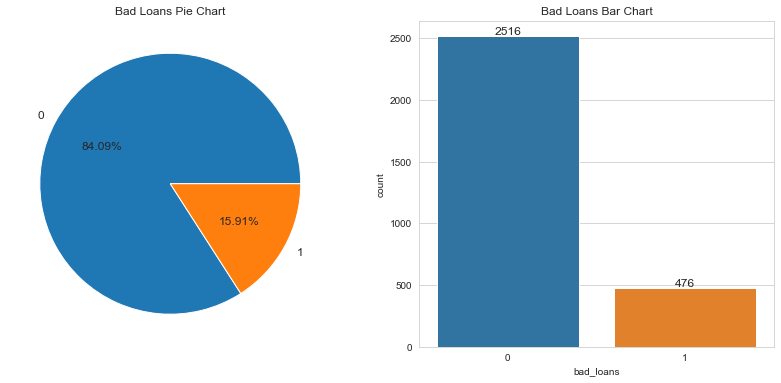

In [8]:
# Pie Chart showing percentages
plt.figure(figsize=(14,6))
plt.subplot(121)
loans["bad_loans"].value_counts().plot.pie(autopct  = "%.2f%%", fontsize=12)
plt.title("Bad Loans Pie Chart")
plt.ylabel("")

# Bar Chart Raw Number
plt.subplot(122)
ax = sns.countplot(x="bad_loans", data=loans)
for i, j in enumerate(loans["bad_loans"].value_counts().values):
    ax.annotate(str(j), (i, j), ha="center", va="bottom", fontsize=12)

plt.title("Bad Loans Bar Chart")
plt.show()

**Observation:** The dataset is unbalanced on bad_loans.

### 4. Dataset Preparation
- Train-Test Split
- Normalise Features
- SMOTE Oversampling

#### 4.1 Train-Test Split 80/20

In [9]:
# Split the dataset: 80% for train, 20% for test
output = "bad_loans"
X = loans.drop(output, axis=1)
y = loans[output]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234, stratify=y)


#### 4.2 Normalize Features using Standard Scaler
- Normalise train and test set separately to prevent leaking of information from the test set
- Use the scaler fitted on the train set to scale the test set. This ensures consistency in the transformation and makes it possible to evaluate if the model can generalize well

In [10]:
features = X_train.columns

In [11]:
X_train_scaled = deepcopy(X_train)
X_test_scaled = deepcopy(X_test)

In [12]:
# Normalize features
scaler = StandardScaler()
scaler = scaler.fit(X_train)

X_train_scaled[features] = scaler.transform(X_train)
X_test_scaled[features] = scaler.transform(X_test)

In [13]:
X_train.head()

,acc_now_delinq,acc_open_past_24mths,all_util,annual_inc,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,collections_12_mths_ex_med,delinq_amnt,...,total_bc_limit,total_cu_tl,total_il_high_credit_limit,total_pymnt,total_pymnt_inv,total_rec_int,total_rec_late_fee,total_rec_prncp,total_rev_hi_lim,delinq_2yrs
1200,0.0,1.0,92.0,400000.0,1991.0,843.0,92.2,0.0,0.0,0.0,...,10800.0,0.0,0.0,1630.710000,1630.71,692.87,0.0,937.84,10800.0,0.0
1083,0.0,2.0,37.0,15300.0,1818.0,7760.0,28.1,0.0,0.0,0.0,...,10800.0,0.0,0.0,3239.212599,3239.21,39.21,0.0,3200.00,19700.0,0.0
2593,0.0,8.0,86.0,120000.0,76200.0,249.0,50.2,0.0,0.0,0.0,...,500.0,3.0,54925.0,1623.250000,1623.25,491.95,0.0,1131.30,2500.0,0.0
1316,0.0,4.0,61.0,58000.0,9697.0,3617.0,59.4,0.0,0.0,0.0,...,8900.0,0.0,59819.0,488.160000,488.16,139.88,0.0,348.28,11000.0,0.0
2500,0.0,3.0,92.0,132000.0,6605.0,24513.0,47.6,0.0,0.0,0.0,...,46800.0,1.0,81670.0,15574.523117,15574.52,574.52,0.0,15000.00,47600.0,0.0


In [14]:
X_train_scaled.head()

,acc_now_delinq,acc_open_past_24mths,all_util,annual_inc,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,collections_12_mths_ex_med,delinq_amnt,...,total_bc_limit,total_cu_tl,total_il_high_credit_limit,total_pymnt,total_pymnt_inv,total_rec_int,total_rec_late_fee,total_rec_prncp,total_rev_hi_lim,delinq_2yrs
1200,-0.028922,-1.194271,1.648873,3.983099,-0.729644,-0.722667,1.518049,-0.133139,-0.163745,-0.027817,...,-0.546420,-0.604186,-1.046418,-0.880171,-0.880064,0.615512,-0.151844,-0.917089,-0.593372,-0.543827
1083,-0.028922,-0.911591,-0.814731,-0.909573,-0.738275,-0.318528,-0.602306,-0.133139,-0.163745,-0.027817,...,-0.546420,-0.604186,-1.046418,-0.730620,-0.730487,-0.778175,-0.151844,-0.704409,-0.367847,-0.543827
2593,-0.028922,0.784486,1.380116,0.422017,2.972719,-0.757372,0.128737,-0.133139,-0.163745,-0.027817,...,-1.034781,0.356490,0.146048,-0.880864,-0.880758,0.187125,-0.151844,-0.898901,-0.803693,-0.543827
1316,-0.028922,-0.346232,0.260296,-0.366508,-0.345184,-0.560591,0.433062,-0.133139,-0.163745,-0.027817,...,-0.636506,-0.604186,0.252301,-0.986399,-0.986311,-0.563533,-0.151844,-0.972518,-0.588304,-0.543827
2500,-0.028922,-0.628912,1.648873,0.574635,-0.499447,0.660295,0.042732,-0.133139,-0.163745,-0.027817,...,1.160472,-0.283961,0.726704,0.416256,0.416591,0.363175,-0.151844,0.404985,0.339137,-0.543827


#### 4.3 Address the Unbalanced Training Set by Oversampling (SMOTE)

In [15]:
# Merge X_train and y_train to obtain the training set
training_set = X_train_scaled.merge(pd.DataFrame(y_train), left_index=True,right_index=True,how = "left")
training_set["bad_loans"].value_counts() # Unbalanced Training Set


0    2012
1     381
Name: bad_loans, dtype: int64

In [16]:
# Address the Unbalanced Training Set by Oversampling SMOTE
sm = SMOTE(random_state=1234)
sm_X_train, sm_y_train = sm.fit_sample(X_train_scaled, y_train.ravel())

In [17]:
pd.Series(sm_y_train).value_counts()

1    2012
0    2012
dtype: int64

### 5. Machine Learning Models
- Logistic Regression
- Decision Tree Classifier
- XGBoost Classifier

#### 5.1 Logistic Regression

In [18]:
# Initialize logistic regression model with L2 penalty: Ridge model
lr = LogisticRegression(fit_intercept=True, 
                        penalty='l2',
                        C = 1,
                        random_state=1234)


##### Evaluation of Logistic Regression
- Cross Validation
- Accuraucy, MCC, Confusion Matrix, AUC

**Cross Validation**

In [19]:
# Create a n-fold cross validation
def cross_validation_smote(splits, X_train, y_train, classifier):
 
    skf = StratifiedKFold(n_splits=splits,random_state=1234)    
    accuracy = []
    recall = []
    precision = []
    f1 = []
    roc_auc = []
    mcc = []
    
    for train_index, test_index in skf.split(X_train, y_train):
        # train-test split in each fold
        X_train_cv, X_test_cv = X_train[train_index], X_train[test_index]
        y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]
        
        # SMOTE oversampling on the training set of the fold 
        pipeline = make_pipeline_imb(SMOTE(random_state = 1234), classifier)
        model = pipeline.fit(X_train_cv, y_train_cv)
        y_pred = model.predict(X_test_cv)
                
        accuracy.append(accuracy_score(y_test_cv, y_pred))
        recall.append(recall_score(y_test_cv, y_pred))
        precision.append(precision_score(y_test_cv, y_pred))
        f1.append(f1_score(y_test_cv, y_pred))
        roc_auc.append(roc_auc_score(y_test_cv, y_pred))
        mcc.append(matthews_corrcoef(y_test_cv, y_pred))
        
    result = {}
    result["accuracy"] = np.mean(accuracy)
    result["recall_score"] = np.mean(recall)
    result["precision"] = np.mean(precision)
    result["f1_score"] = np.mean(f1)
    result["roc_auc_score"] = np.mean(roc_auc)
    result["mcc"] = np.mean(mcc)
        
    compiler_acc = []
    compiler_mcc = []

    for fold, acc in enumerate(accuracy):
        compiler_acc.append([fold+1, acc])         

    for fold, mcc_ in enumerate(mcc):
        compiler_mcc.append([fold+1, mcc_])
    
    result_acc = pd.DataFrame(compiler_acc,columns=["Fold","Accuracy"])
    result_mcc = pd.DataFrame(compiler_mcc,columns=["Fold","MCC"])
    
    fig = plt.figure(figsize=(12,4))
    
    plt.subplot(121)    
    plt.plot(result_acc.Fold,result_acc.Accuracy)
    plt.hlines(np.mean(accuracy),1,splits,colors='r', linestyles='dashed')
    plt.text(splits-1.5,np.mean(accuracy)+0.001, f"Average Accuracy:{round(np.mean(accuracy),4)}")
    plt.xticks(np.arange(1, 6, step=1))
    plt.title('Cross Validation Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Iteration')
        
    plt.subplot(122)
    plt.plot(result_mcc.Fold,result_mcc.MCC)
    plt.hlines(np.mean(mcc),1,splits,colors='r', linestyles='dashed')
    plt.text(splits-1.5,np.mean(mcc)+0.001, f"Average MCC:{round(np.mean(mcc),4)}")
    plt.xticks(np.arange(1, 6, step=1))
    plt.title('Cross Validation MCC')
    plt.ylabel('MCC')
    plt.xlabel('Iteration')
    
    return result

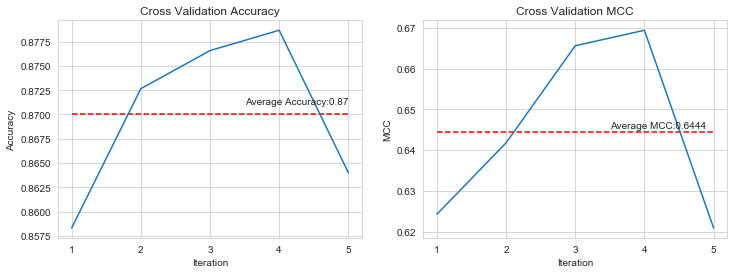

In [20]:
results = cross_validation_smote(5, X_train_scaled.values, y_train.values, lr)

In [21]:
print("Cross Validation Results")

for key in results:
    print("{0}: {1}".format(key, np.mean(results[key])))


Cross Validation Results
accuracy: 0.8700463104503513
recall_score: 0.9107655502392344
precision: 0.5563261416856621
f1_score: 0.6906533497777116
roc_auc_score: 0.8865476702469582
mcc: 0.6443789427177233


**Test Results**

In [22]:
# Initialize logistic regression model with L2 penalty: Ridge model
lr = LogisticRegression(fit_intercept=True, 
                        penalty='l2',
                        C = 1,
                        random_state=1234)


In [23]:
lr.fit(sm_X_train, sm_y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=1234, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [24]:
y_pred_lr = lr.predict(X_test_scaled)

In [25]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_lr)
TN, FP, FN, TP = cm.ravel()
print (cm)
print (TN, FP, FN, TP)

[[432  72]
 [  9  86]]
432 72 9 86


In [26]:
# Performance of Logistic Regression with L2
print ("Accuracy: ", accuracy_score(y_test, y_pred_lr))
print("Sensitivity: ", recall_score(y_test, y_pred_lr))
print("Precision: ", precision_score(y_test, y_pred_lr))
print ("f1 Score: ", f1_score(y_test, y_pred_lr))
print("ROC_AUC_Score:", roc_auc_score(y_test, y_pred_lr))
print("MCC: ", matthews_corrcoef(y_test, y_pred_lr))


Accuracy:  0.8647746243739566
Sensitivity:  0.9052631578947369
Precision:  0.5443037974683544
f1 Score:  0.6798418972332017
ROC_AUC_Score: 0.8812030075187971
MCC:  0.6319977711735533


In [27]:
def cm_and_roc(confusion_matrix, class_names, Y_test, testPredict, figsize = (15,5), fontsize=12):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    
    # Confusion Matrix
    plt.subplot(121)
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title("Confusion Matrix")
    
    # ROC 
    plt.subplot(122)

    # Plot ROC Curve
    fpr, tpr, thresholds = roc_curve(Y_test, testPredict) # fpr: FP Rate, tpr: TP Rate, thresholds: Pr(y=1)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.1])
    plt.ylim([-0.1,1.1])
    plt.title('Receiver operating characteristic')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    return

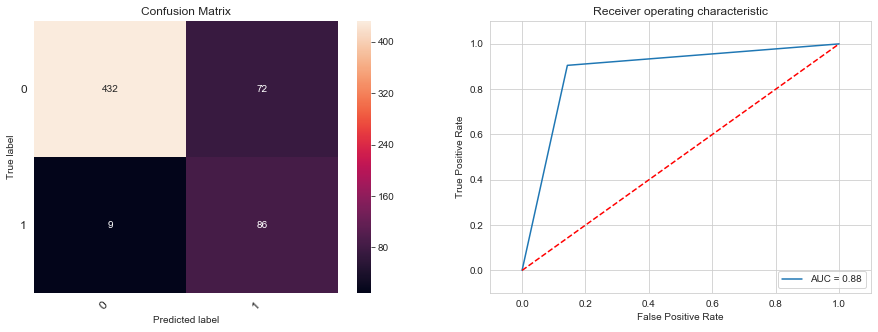

In [28]:
cm_and_roc(cm, [0, 1], y_test, y_pred_lr, figsize = (15,5), fontsize=12)

#### 5.2 Decision Tree Classifier

In [29]:
# Initialize Decision Tree Classifier model
tree = DecisionTreeClassifier(criterion='entropy', # Entropy and information gain
                              max_depth=7, # Stopping condition: maximum tree depth
                              min_samples_split=30, # Stopping condition: Minimum number of samples required to split an internal node
                              min_samples_leaf=10, # Stopping condition: Minimum number of samples required to be at a leaf node
                              min_impurity_decrease=0.005, # Stopping condition: A node will be split if this split induces a decrease of the impurity greater than or equal to this value
                              random_state=1234 # Set seed to 1234
                             )

In [30]:
tree.fit(sm_X_train, sm_y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=7,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.005, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=30,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1234, splitter='best')

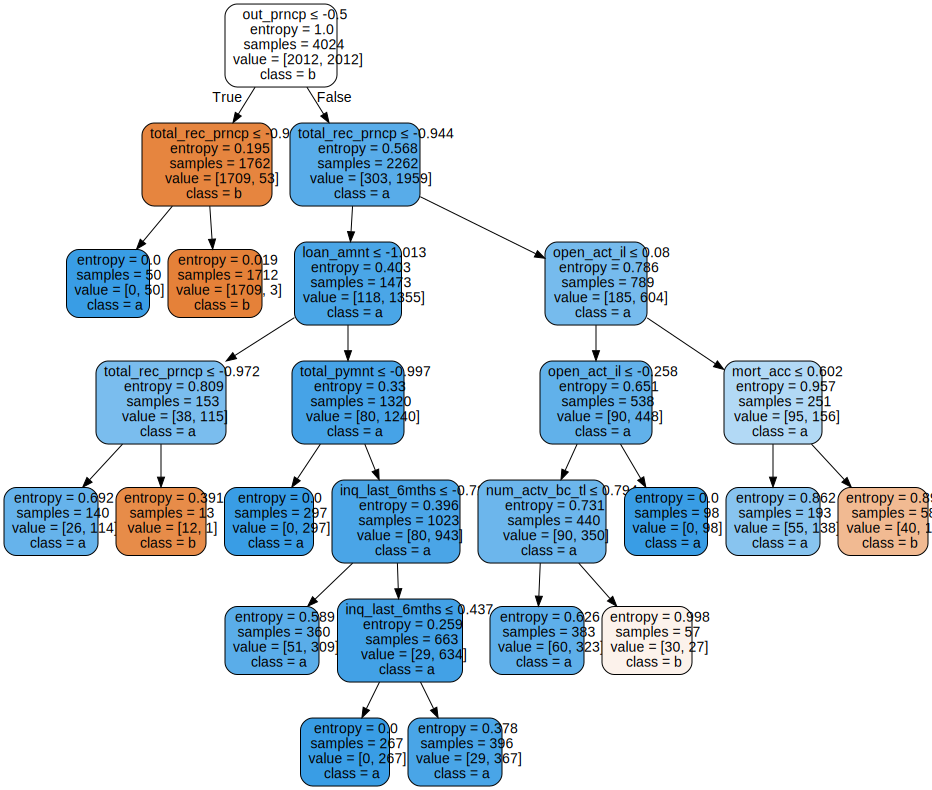

In [31]:
dot_data = export_graphviz(tree, out_file=None, feature_names=features.tolist(), class_names=output, 
                           filled=True, rounded=True, special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

##### Evaluation of Decision Tree Classifier
- Cross Validation
- Accuraucy, MCC, Confusion Matrix, AUC

**Cross Validation**

In [32]:
# Initialize Decision Tree Classifier model
tree = DecisionTreeClassifier(criterion='entropy', # Entropy and information gain
                              max_depth=7, # Stopping condition: maximum tree depth
                              min_samples_split=30, # Stopping condition: Minimum number of samples required to split an internal node
                              min_samples_leaf=10, # Stopping condition: Minimum number of samples required to be at a leaf node
                              min_impurity_decrease=0.005, # Stopping condition: A node will be split if this split induces a decrease of the impurity greater than or equal to this value
                              random_state=1234 # Set seed to 1234
                             )

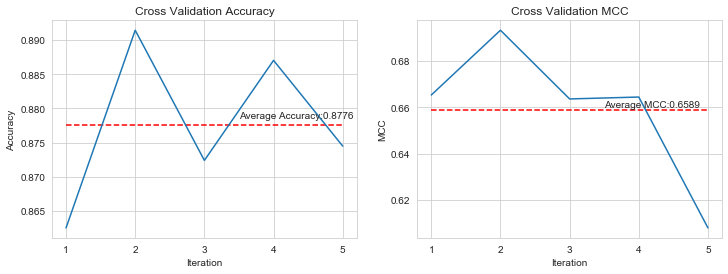

In [33]:
results = cross_validation_smote(5, X_train_scaled.values, y_train.values, tree)


In [34]:
print("Cross Validation Results")

for key in results:
    print("{0}: {1}".format(key, np.mean(results[key])))


Cross Validation Results
accuracy: 0.8775663428865925
recall_score: 0.9105604921394395
precision: 0.5745055052328066
f1_score: 0.7029482242950678
roc_auc_score: 0.890921518615181
mcc: 0.6589197545914296


**Test Results**

In [35]:
# Initialize Decision Tree Classifier model
tree = DecisionTreeClassifier(criterion='entropy', # Entropy and information gain
                              max_depth=7, # Stopping condition: maximum tree depth
                              min_samples_split=30, # Stopping condition: Minimum number of samples required to split an internal node
                              min_samples_leaf=10, # Stopping condition: Minimum number of samples required to be at a leaf node
                              min_impurity_decrease=0.005, # Stopping condition: A node will be split if this split induces a decrease of the impurity greater than or equal to this value
                              random_state=1234 # Set seed to 1234
                             )

In [36]:
tree.fit(sm_X_train, sm_y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=7,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.005, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=30,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1234, splitter='best')

In [37]:
y_pred_tree = tree.predict(X_test_scaled)

In [38]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_tree)
TN, FP, FN, TP = cm.ravel()
print (cm)
print (TN, FP, FN, TP)

[[447  57]
 [ 14  81]]
447 57 14 81


In [39]:
# Performance of Logistic Regression with L1
print ("Accuracy: ", accuracy_score(y_test, y_pred_tree))
print("Sensitivity: ", recall_score(y_test, y_pred_tree))
print("Precision: ", precision_score(y_test, y_pred_tree))
print ("f1 Score: ", f1_score(y_test, y_pred_tree))
print("ROC_AUC_Score:", roc_auc_score(y_test, y_pred_tree))
print("MCC: ", matthews_corrcoef(y_test, y_pred_tree))


Accuracy:  0.8814691151919867
Sensitivity:  0.8526315789473684
Precision:  0.5869565217391305
f1 Score:  0.6952789699570816
ROC_AUC_Score: 0.8697681704260651
MCC:  0.641573747942312


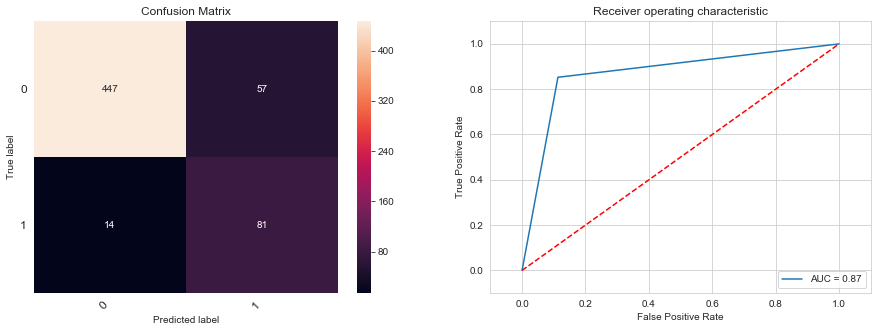

In [40]:
cm_and_roc(cm, [0, 1], y_test, y_pred_tree, figsize = (15,5), fontsize=12)



#### 5.3 XGBoost

In [41]:
# Initialize XGBoost
xgboost = xgb.XGBClassifier(n_estimators=500, 
                            random_state=1234,
                            max_depth=7, 
                            reg_alpha=1, 
                            reg_lambda=2,
                            gamma=1,
                            min_child_weight=5
                           )


##### Evaluation of Decision Tree Classifier
- Cross Validation
- Accuraucy, MCC, Confusion Matrix, AUC

**Cross Validation**

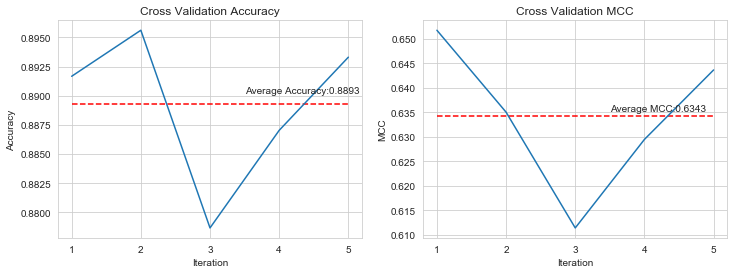

In [42]:
results = cross_validation_smote(5, X_train_scaled.values, y_train.values, xgboost)


In [43]:
print("Cross Validation Results")

for key in results:
    print("{0}: {1}".format(key, np.mean(results[key])))


Cross Validation Results
accuracy: 0.8892556697909114
recall_score: 0.7873205741626796
precision: 0.6207097576820297
f1_score: 0.693710796301666
roc_auc_score: 0.8479317338178802
mcc: 0.6342564678950552


**Test Results**

In [44]:
# Initialize XGBoost
xgboost = xgb.XGBClassifier(n_estimators=500, 
                            random_state=1234,
                            max_depth=7, 
                            reg_alpha=1, 
                            reg_lambda=2,
                            gamma=1,
                            min_child_weight=5
                           )


In [45]:
xgboost.fit(sm_X_train, sm_y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=1,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=5, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=1234,
              reg_alpha=1, reg_lambda=2, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [46]:
y_pred_xgb = xgboost.predict(X_test_scaled.values)

In [47]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_xgb)
TN, FP, FN, TP = cm.ravel()
print (cm)
print (TN, FP, FN, TP)

[[463  41]
 [ 17  78]]
463 41 17 78


In [48]:
# Performance of Logistic Regression with L1
print ("Accuracy: ", accuracy_score(y_test, y_pred_xgb))
print("Sensitivity: ", recall_score(y_test, y_pred_xgb))
print("Precision: ", precision_score(y_test, y_pred_xgb))
print ("f1 Score: ", f1_score(y_test, y_pred_xgb))
print("ROC_AUC_Score:", roc_auc_score(y_test, y_pred_xgb))
print("MCC: ", matthews_corrcoef(y_test, y_pred_xgb))


Accuracy:  0.9031719532554258
Sensitivity:  0.8210526315789474
Precision:  0.6554621848739496
f1 Score:  0.7289719626168224
ROC_AUC_Score: 0.8698517126148704
MCC:  0.6772368814648807


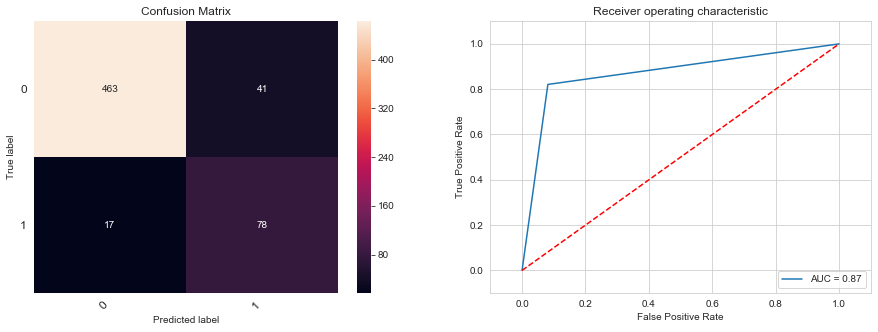

In [49]:
cm_and_roc(cm, [0, 1], y_test, y_pred_xgb, figsize = (15,5), fontsize=12)



## Question 2

(2 points) Describe the strategy you took in terms of training the data and selecting the appropriate parameters to best avoid overfitting. This should also be applied in the above and subsequent questions for consistency. *Hint -you may further divide the training data*

<u>Data used for Training</u>

1. SMOTE Oversampling instead of Resampling on existing dataset

SMOTE addresses the unbalanced training set and reduces information leakage by creating synthetic data points which are similar to the existing ones using nearest neighbors classification instead of duplicating existing data points. This, therefore, helps to reduce overfitting.

2. Oversample only on the training set rather than on the entire dataset

If oversampling is done before splitting into the training and test sets, there will be information leakage from test set into the training set. SMOTE algorithm works by using nearest neighbors of observations to create synthetic data. 

When SMOTE is applied to the entire data, there is a chance that the nearest neighbors of minority class observations in the training setare in the test set. This means that information in the test set is partially captured by the synthetic data in the training set. 

As a result, the model will be able to better predict the test set values than a completely unseen data, causing an overfitting problem.

3. Stratified Cross-Validation

The goal of cross validation is to assess how the model will generalise to an independent data set. This can be evaluated by looking at the deviation between the validation and test error. If there is a large deviation, then there is a high chance of overfitting. 

Specifically, in k-fold cross validation, every data point gets to be in a validation set exactly once, and gets to be in a training set k-1 times. This significantly reduces underfitting and  as we are using most of the data for fitting, and also significantly reduces overfitting as most of the data is also being used in the validation set.

Stratification is also factor into the cross validation. Stratification is a technique where we rearrange the data in a way that each fold has a good representation of the whole dataset. This approach ensures that one class of data is not overrepresented especially when the target variable is unbalanced.

4. Oversample during Cross-Validation instead of before Cross-Validation

SMOTE oversampling is done on all training folds during the process of cross validation rather than on the entire training set before cross validation. This is achieved by creating a SMOTE pipeline at each iteration. This will give us a more representative cross validation results when we compare it to the test results. This is because the test set does not contain any SMOTE oversampled data points and only data from the original dataset. Therefore, our validation set should not contain SMOTE oversampled data points as well.

**Refer to report for explanation of selected parameters to avoid overfitting**

# Reduced model

Not all of the attributes will be useful for predicting if a loan will default. The next step is to reduce this number of attributes to get a more parsimonious model, while still being able to predict default well. 

## Question 3

(2 points) Which loan attributes do you believe are the most informative? Please use your **knoweledge and intuition** to choose 10 of the attributes available, and explain why you chose these attributes. Let's call this the REDUCED-MODEL.

**Refer to report for explanation of the 10 selected features/attributes**

**10 Features**:
- int_rate
- total_pymnt
- total_pymnt_inv
- revol_bal
- dti
- out_prncp
- pub_rec_bankruptcies
- chargeoff_within_12_mths
- tot_cur_bal
- tot_hi_cred_lim

In [50]:
selected_ten_features = ["int_rate", 
                         "total_pymnt", 
                         "total_pymnt_inv", 
                         "revol_bal", 
                         "dti", 
                         "out_prncp", 
                         "pub_rec_bankruptcies", 
                         "chargeoff_within_12_mths", 
                         "tot_cur_bal", 
                         "tot_hi_cred_lim"
                        ]


## Question 4

(2 points) Let's use the attributes you've selected for the reduced model to predict default, and check the performance of the resulting models. Apply the same three techniques (logistic regression, tree classification, and xgboost) to the REDUCED-MODEL (i.e. only using the attributes you selected) to predict loan default. Again, compute their accuracy and MCC

### 4.1 Dataset Preparation
- Train-Test Split
- Normalise Features
- SMOTE Oversampling

#### 4.1.1 Train-Test Split 80/20

In [51]:
# Split the dataset: 80% for train, 20% for test
output = "bad_loans"
X_r = loans[selected_ten_features]
y_r = loans[output]

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_r, y_r, test_size=0.2, random_state=1234, stratify=y_r)


#### 4.1.2 Normalize Features using Standard Scaler
- Normalise train and test set separately to prevent leaking of information from the test set
- Use the scaler fitted on the train set to scale the test set. This ensures consistency in the transformation and makes it possible to evaluate if the model can generalize well

In [52]:
X_train_scaled_r = deepcopy(X_train_r)
X_test_scaled_r = deepcopy(X_test_r)

In [53]:
# Normalize features
scaler = StandardScaler()
scaler = scaler.fit(X_train_r)

X_train_scaled_r[selected_ten_features] = scaler.transform(X_train_r)
X_test_scaled_r[selected_ten_features] = scaler.transform(X_test_r)

In [54]:
X_train_r.head()

,int_rate,total_pymnt,total_pymnt_inv,revol_bal,dti,out_prncp,pub_rec_bankruptcies,chargeoff_within_12_mths,tot_cur_bal,tot_hi_cred_lim
1200,20.00,1630.710000,1630.71,9957.0,1.04,14062.16,1.0,0.0,9957.0,10800.0
1083,11.99,3239.212599,3239.21,7271.0,18.82,0.00,0.0,0.0,7271.0,19700.0
2593,11.99,1623.250000,1623.25,1034.0,10.69,10868.70,0.0,0.0,381000.0,390910.0
1316,11.99,488.160000,488.16,6695.0,12.91,14651.72,0.0,0.0,67876.0,70819.0
2500,16.02,15574.523117,15574.52,22794.0,14.84,0.00,0.0,0.0,118898.0,129270.0


In [55]:
X_train_scaled_r.head()

,int_rate,total_pymnt,total_pymnt_inv,revol_bal,dti,out_prncp,pub_rec_bankruptcies,chargeoff_within_12_mths,tot_cur_bal,tot_hi_cred_lim
1200,0.998138,-0.880171,-0.880064,-0.150265,-1.044104,1.069451,2.840504,-0.133139,-0.865808,-0.974444
1083,-0.476178,-0.730620,-0.730487,-0.243488,0.052137,-0.501512,-0.328413,-0.133139,-0.880202,-0.931298
2593,-0.476178,-0.880864,-0.880758,-0.459955,-0.449125,0.712691,-0.328413,-0.133139,1.122626,0.868276
1316,-0.476178,-0.986399,-0.986311,-0.263479,-0.312249,1.135314,-0.328413,-0.133139,-0.555418,-0.683480
2500,0.265582,0.416256,0.416591,0.295267,-0.193254,-0.501512,-0.328413,-0.133139,-0.281989,-0.400118


#### 4.1.3 Address the Unbalanced Training Set by Oversampling (SMOTE)

In [56]:
# Merge X_train and y_train to obtain the training set
training_set_r = X_train_scaled_r.merge(pd.DataFrame(y_train_r), left_index=True,right_index=True,how = "left")
training_set_r["bad_loans"].value_counts() # Unbalanced Training Set


0    2012
1     381
Name: bad_loans, dtype: int64

In [57]:
# Address the Unbalanced Training Set by Oversampling SMOTE
sm = SMOTE(random_state=1234)
sm_X_train_r, sm_y_train_r = sm.fit_sample(X_train_scaled_r, y_train_r.ravel())

In [58]:
pd.Series(sm_y_train_r).value_counts()

1    2012
0    2012
dtype: int64

### 4.2 Machine Learning Models
- Logistic Regression
- Decision Tree Classifier
- XGBoost Classifier

#### 4.2.1 Logistic Regression

In [59]:
# Initialize logistic regression model with L2 penalty: Ridge model
lr = LogisticRegression(fit_intercept=True, 
                        penalty='l2',
                        C = 1,
                        random_state=1234)


##### Evaluation of Logistic Regression
- Cross Validation
- Accuraucy, MCC, Confusion Matrix, AUC

**Cross Validation**

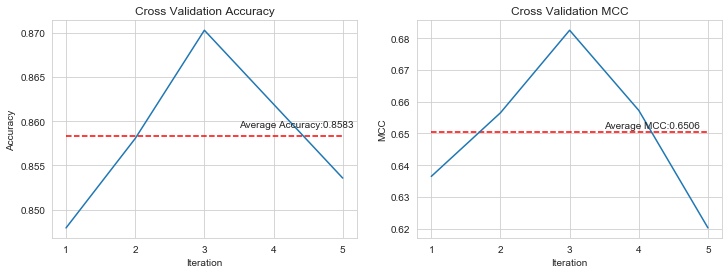

In [60]:
results = cross_validation_smote(5, X_train_scaled_r.values, y_train_r.values, lr)

In [61]:
print("Cross Validation Results")

for key in results:
    print("{0}: {1}".format(key, np.mean(results[key])))


Cross Validation Results
accuracy: 0.8583456607064346
recall_score: 0.971120984278879
precision: 0.5302424451324232
f1_score: 0.6858509919901795
roc_auc_score: 0.9040536343687398
mcc: 0.6505799870692652


**Test Results**

In [62]:
# Initialize logistic regression model with L2 penalty: Ridge model
lr = LogisticRegression(fit_intercept=True, 
                        penalty='l2',
                        C = 1,
                        random_state=1234)


In [63]:
lr.fit(sm_X_train_r, sm_y_train_r)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=1234, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [64]:
y_pred_lr = lr.predict(X_test_scaled_r)

In [65]:
# Create confusion matrix
cm = confusion_matrix(y_test_r, y_pred_lr)
TN, FP, FN, TP = cm.ravel()
print (cm)
print (TN, FP, FN, TP)

[[415  89]
 [  3  92]]
415 89 3 92


In [66]:
# Performance of Logistic Regression with L2
print ("Accuracy: ", accuracy_score(y_test_r, y_pred_lr))
print("Sensitivity: ", recall_score(y_test_r, y_pred_lr))
print("Precision: ", precision_score(y_test_r, y_pred_lr))
print ("f1 Score: ", f1_score(y_test_r, y_pred_lr))
print("ROC_AUC_Score:", roc_auc_score(y_test_r, y_pred_lr))
print("MCC: ", matthews_corrcoef(y_test_r, y_pred_lr))


Accuracy:  0.8464106844741235
Sensitivity:  0.968421052631579
Precision:  0.5082872928176796
f1 Score:  0.6666666666666667
ROC_AUC_Score: 0.8959168755221386
MCC:  0.6299174678701741


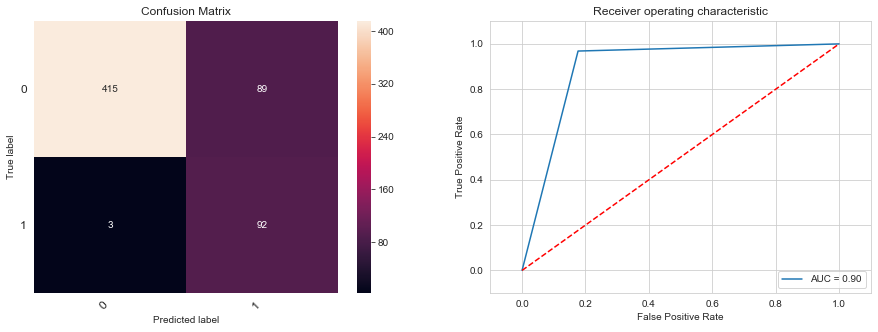

In [67]:
cm_and_roc(cm, [0, 1], y_test_r, y_pred_lr, figsize = (15,5), fontsize=12)

#### 4.2.2 Decision Tree Classifier

In [68]:
# Initialize Decision Tree Classifier model
tree = DecisionTreeClassifier(criterion='entropy', # Entropy and information gain
                              max_depth=7, # Stopping condition: maximum tree depth
                              min_samples_split=30, # Stopping condition: Minimum number of samples required to split an internal node
                              min_samples_leaf=10, # Stopping condition: Minimum number of samples required to be at a leaf node
                              min_impurity_decrease=0.005, # Stopping condition: A node will be split if this split induces a decrease of the impurity greater than or equal to this value
                              random_state=1234 # Set seed to 1234
                             )

In [69]:
tree.fit(sm_X_train_r, sm_y_train_r)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=7,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.005, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=30,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1234, splitter='best')

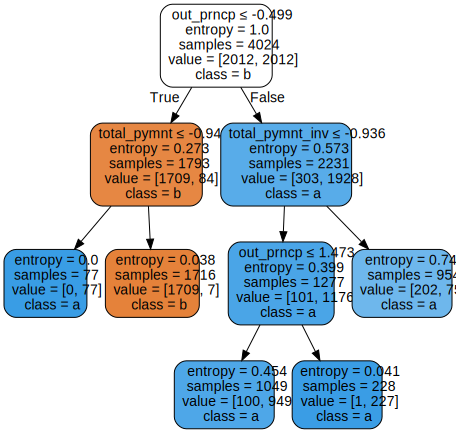

In [70]:
dot_data = export_graphviz(tree, out_file=None, feature_names=selected_ten_features, class_names=output, 
                           filled=True, rounded=True, special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

##### Evaluation of Decision Tree Classifier
- Cross Validation
- Accuraucy, MCC, Confusion Matrix, AUC

**Cross Validation**

In [71]:
# Initialize Decision Tree Classifier model
tree = DecisionTreeClassifier(criterion='entropy', # Entropy and information gain
                              max_depth=7, # Stopping condition: maximum tree depth
                              min_samples_split=30, # Stopping condition: Minimum number of samples required to split an internal node
                              min_samples_leaf=10, # Stopping condition: Minimum number of samples required to be at a leaf node
                              min_impurity_decrease=0.005, # Stopping condition: A node will be split if this split induces a decrease of the impurity greater than or equal to this value
                              random_state=1234 # Set seed to 1234
                             )

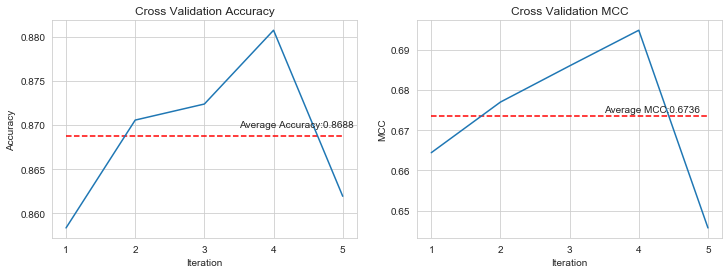

In [72]:
results = cross_validation_smote(5, X_train_scaled_r.values, y_train_r.values, tree)


In [73]:
print("Cross Validation Results")

for key in results:
    print("{0}: {1}".format(key, np.mean(results[key])))


Cross Validation Results
accuracy: 0.8687919538322225
recall_score: 0.9842105263157895
precision: 0.5494164226693293
f1_score: 0.7050415707705797
roc_auc_score: 0.9155679744155025
mcc: 0.6735809717133252


**Test Results**

In [74]:
# Initialize Decision Tree Classifier model
tree = DecisionTreeClassifier(criterion='entropy', # Entropy and information gain
                              max_depth=7, # Stopping condition: maximum tree depth
                              min_samples_split=30, # Stopping condition: Minimum number of samples required to split an internal node
                              min_samples_leaf=10, # Stopping condition: Minimum number of samples required to be at a leaf node
                              min_impurity_decrease=0.005, # Stopping condition: A node will be split if this split induces a decrease of the impurity greater than or equal to this value
                              random_state=1234 # Set seed to 1234
                             )

In [75]:
tree.fit(sm_X_train_r, sm_y_train_r)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=7,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.005, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=30,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1234, splitter='best')

In [76]:
y_pred_tree = tree.predict(X_test_scaled_r)

In [77]:
# Create confusion matrix
cm = confusion_matrix(y_test_r, y_pred_tree)
TN, FP, FN, TP = cm.ravel()
print (cm)
print (TN, FP, FN, TP)

[[423  81]
 [  4  91]]
423 81 4 91


In [78]:
# Performance of Logistic Regression with L1
print ("Accuracy: ", accuracy_score(y_test_r, y_pred_tree))
print("Sensitivity: ", recall_score(y_test_r, y_pred_tree))
print("Precision: ", precision_score(y_test_r, y_pred_tree))
print ("f1 Score: ", f1_score(y_test_r, y_pred_tree))
print("ROC_AUC_Score:", roc_auc_score(y_test_r, y_pred_tree))
print("MCC: ", matthews_corrcoef(y_test_r, y_pred_tree))


Accuracy:  0.8580968280467446
Sensitivity:  0.9578947368421052
Precision:  0.5290697674418605
f1 Score:  0.6816479400749065
ROC_AUC_Score: 0.8985902255639098
MCC:  0.6436585611363641


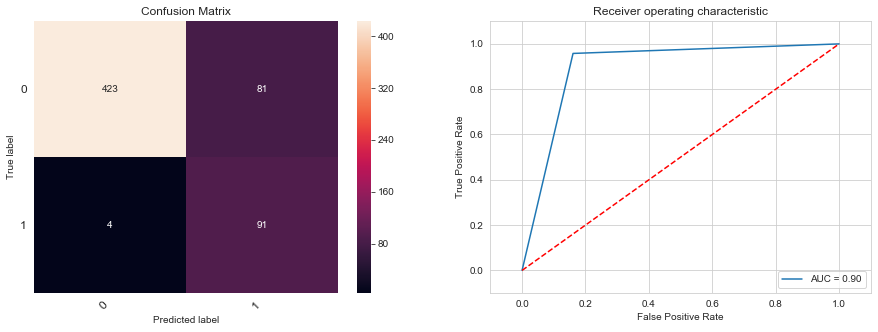

In [79]:
cm_and_roc(cm, [0, 1], y_test_r, y_pred_tree, figsize = (15,5), fontsize=12)



#### 4.2.3 XGBoost

In [80]:
# Initialize XGBoost
xgboost = xgb.XGBClassifier(n_estimators=500, 
                            random_state=1234,
                            max_depth=7, 
                            reg_alpha=1, 
                            reg_lambda=2,
                            gamma=1,
                            min_child_weight=5
                           )


##### Evaluation of Decision Tree Classifier
- Cross Validation
- Accuraucy, MCC, Confusion Matrix, AUC

**Cross Validation**

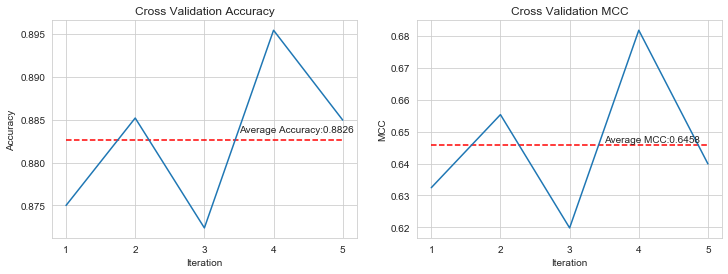

In [81]:
results = cross_validation_smote(5, X_train_scaled_r.values, y_train_r.values, xgboost)


In [82]:
print("Cross Validation Results")

for key in results:
    print("{0}: {1}".format(key, np.mean(results[key])))


Cross Validation Results
accuracy: 0.8825794236598213
recall_score: 0.8556390977443609
precision: 0.591049937971831
f1_score: 0.6990048992880308
roc_auc_score: 0.8716586659419188
mcc: 0.6458248426306537


**Test Results**

In [83]:
# Initialize XGBoost
xgboost = xgb.XGBClassifier(n_estimators=500, 
                            random_state=1234,
                            max_depth=7, 
                            reg_alpha=1, 
                            reg_lambda=2,
                            gamma=1,
                            min_child_weight=5
                           )


In [84]:
xgboost.fit(sm_X_train_r, sm_y_train_r)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=1,
              learning_rate=0.1, max_delta_step=0, max_depth=7,
              min_child_weight=5, missing=None, n_estimators=500, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=1234,
              reg_alpha=1, reg_lambda=2, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [85]:
y_pred_xgb = xgboost.predict(X_test_scaled_r.values)

In [86]:
# Create confusion matrix
cm = confusion_matrix(y_test_r, y_pred_xgb)
TN, FP, FN, TP = cm.ravel()
print (cm)
print (TN, FP, FN, TP)

[[448  56]
 [ 21  74]]
448 56 21 74


In [87]:
# Performance of Logistic Regression with L1
print ("Accuracy: ", accuracy_score(y_test_r, y_pred_xgb))
print("Sensitivity: ", recall_score(y_test_r, y_pred_xgb))
print("Precision: ", precision_score(y_test_r, y_pred_xgb))
print ("f1 Score: ", f1_score(y_test_r, y_pred_xgb))
print("ROC_AUC_Score:", roc_auc_score(y_test_r, y_pred_xgb))
print("MCC: ", matthews_corrcoef(y_test_r, y_pred_xgb))


Accuracy:  0.8714524207011686
Sensitivity:  0.7789473684210526
Precision:  0.5692307692307692
f1 Score:  0.6577777777777778
ROC_AUC_Score: 0.8339181286549707
MCC:  0.5918190859289546


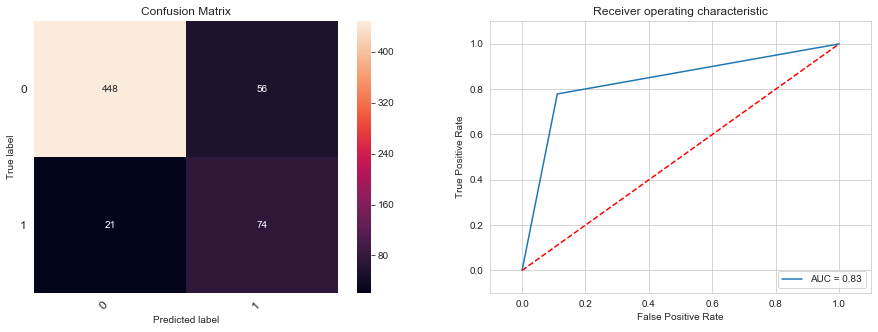

In [88]:
cm_and_roc(cm, [0, 1], y_test_r, y_pred_xgb, figsize = (15,5), fontsize=12)



# Lasso-reduced model

Let's now try to use a statistical approach to select the variables.

## Question 5

(a) (2 points) Calculate the accuracy and MCC of the LASSO approach, and compare it to previous methods. Apply the LASSO to the default response variable (1 or 0), and the entire set of 70 attributes, and constrain the model to have at most ten attributes in it. Find the best lambda. Let's call this the LASSO-MODEL.
<br>
<br>
Which attributes are those?
<br>
<br>
Compute the method's accuracy and MCC using 5-fold cross validation

In [89]:
# Initialize logistic regression model with L1 penalty: Lasso model
lr_1 = LogisticRegression(fit_intercept=True, penalty='l1', random_state=1234)


### 5.1 Find the best regularization parameter that limits to at most 10 coefficients

In [90]:
# A list of regularization parameters/lambdas
lbd = np.logspace(-3, 3, 500)
lbd

array([1.00000000e-03, 1.02807322e-03, 1.05693455e-03, 1.08660611e-03,
       1.11711065e-03, 1.14847155e-03, 1.18071285e-03, 1.21385926e-03,
       1.24793621e-03, 1.28296980e-03, 1.31898690e-03, 1.35601511e-03,
       1.39408283e-03, 1.43321923e-03, 1.47345431e-03, 1.51481892e-03,
       1.55734477e-03, 1.60106446e-03, 1.64601150e-03, 1.69222035e-03,
       1.73972643e-03, 1.78856616e-03, 1.83877698e-03, 1.89039738e-03,
       1.94346693e-03, 1.99802631e-03, 2.05411735e-03, 2.11178304e-03,
       2.17106760e-03, 2.23201647e-03, 2.29467637e-03, 2.35909533e-03,
       2.42532274e-03, 2.49340937e-03, 2.56340741e-03, 2.63537052e-03,
       2.70935387e-03, 2.78541416e-03, 2.86360972e-03, 2.94400048e-03,
       3.02664806e-03, 3.11161583e-03, 3.19896892e-03, 3.28877429e-03,
       3.38110078e-03, 3.47601918e-03, 3.57360225e-03, 3.67392478e-03,
       3.77706369e-03, 3.88309805e-03, 3.99210913e-03, 4.10418050e-03,
       4.21939808e-03, 4.33785019e-03, 4.45962763e-03, 4.58482375e-03,
      

#### 5.1.1 Identify lambda that leads to at most 10 coefficients

In [91]:
coefs = []
parameters = []

# Train the model with different regularization strengths
for a in lbd:
    lr_1.set_params(C=1/a) # Note that C is inverse value of regalurization factor lambda
    lr_1.fit(sm_X_train, sm_y_train)
    coefficients = lr_1.coef_[0]
    count = len(list(filter(lambda f: f!=0, coefficients)))
    
    if count <= 10:
        coefs.append(coefficients)
        parameters.append(a)
    

In [92]:
parameters

[64.508840892677,
 66.31981202212675,
 68.18162294944479,
 70.09570091165618,
 72.06351321293045,
 74.08656834939568,
 76.16641716552891,
 78.30465404301182,
 80.50291812295973,
 82.76289456246352,
 85.08631582640582,
 87.47496301554415,
 89.93066723187614,
 92.4553109823358,
 95.05082962189512,
 97.71921283717997,
 100.46250617173403,
 103.28281259410296,
 106.18229410993847,
 109.16317341936147,
 112.22773562085071,
 115.37832996296596,
 118.61737164524791,
 121.94734366967383,
 125.37079874409197,
 128.89036123908915,
 132.5087291997954,
 136.22867641416468,
 140.05305453932198,
 143.98479528760066,
 148.02691267395102,
 152.1825053264387,
 156.45475886160958,
 160.8469483265355,
 165.36244070941822,
 170.0046975206718,
 174.77727744646808,
 179.68383907677193,
 184.7281437099636,
 189.91405823619354,
 195.2455581016861,
 200.72673035625684,
 206.36177678638566,
 212.15501713624525,
 218.11089241915198,
 224.2339683219845,
 230.52893870517062,
 237.00062920093305,
 243.6540009125466

In [93]:
len(parameters)

100

#### 5.1.2 Find optimal lambda

In [94]:
# Roughly find range of lambdas that limit to 10 features
lower_index, upper_index = 0, 0
for i in range(len(coefs)):
    if len(list(filter(lambda f: f!=0, coefs[i+1]))) == 10:
        lower_index, upper_index = i, i+1
        break
        
print(parameters[lower_index], parameters[upper_index])

64.508840892677 66.31981202212675


In [95]:
low_range, high_range = parameters[lower_index], parameters[upper_index]

In [96]:
# Create multiple regularization strength paramaters: lambdas
lbd = np.linspace(low_range, high_range, 100)
lbd

array([64.50884089, 64.52713353, 64.54542617, 64.56371881, 64.58201144,
       64.60030408, 64.61859672, 64.63688936, 64.65518199, 64.67347463,
       64.69176727, 64.71005991, 64.72835254, 64.74664518, 64.76493782,
       64.78323046, 64.8015231 , 64.81981573, 64.83810837, 64.85640101,
       64.87469365, 64.89298628, 64.91127892, 64.92957156, 64.9478642 ,
       64.96615683, 64.98444947, 65.00274211, 65.02103475, 65.03932739,
       65.05762002, 65.07591266, 65.0942053 , 65.11249794, 65.13079057,
       65.14908321, 65.16737585, 65.18566849, 65.20396112, 65.22225376,
       65.2405464 , 65.25883904, 65.27713167, 65.29542431, 65.31371695,
       65.33200959, 65.35030223, 65.36859486, 65.3868875 , 65.40518014,
       65.42347278, 65.44176541, 65.46005805, 65.47835069, 65.49664333,
       65.51493596, 65.5332286 , 65.55152124, 65.56981388, 65.58810652,
       65.60639915, 65.62469179, 65.64298443, 65.66127707, 65.6795697 ,
       65.69786234, 65.71615498, 65.73444762, 65.75274025, 65.77

In [97]:
# Find lambdas that limit to exactly 10 coefficients
lr_1 = LogisticRegression(fit_intercept=True, penalty='l1', random_state=1234)

coefs = [] 
parameters = []

# Train the model with different regularisation strengths
for a in lbd:
    lr_1.set_params(C=1/a) # Note that C is inverse value of regularization factor lambda
    lr_1.fit(sm_X_train, sm_y_train)
    coefficients = lr_1.coef_[0]
    count = len(list(filter(lambda f: f!=0, coefficients)))
    
    if count == 10:
        coefs.append(coefficients)
        parameters.append(a)      

In [98]:
parameters

[64.508840892677,
 64.52713353034821,
 64.54542616801942,
 64.56371880569063,
 64.58201144336184,
 64.60030408103304,
 64.61859671870425,
 64.63688935637546,
 64.65518199404667,
 64.67347463171788,
 64.6917672693891,
 64.71005990706031,
 64.72835254473152,
 64.74664518240273,
 64.76493782007394,
 64.78323045774515,
 64.80152309541636,
 64.81981573308757,
 64.83810837075877,
 64.85640100842998,
 64.87469364610119,
 64.8929862837724,
 64.91127892144361,
 64.92957155911482,
 64.94786419678603,
 64.96615683445724,
 64.98444947212845,
 65.00274210979966,
 65.02103474747086,
 65.03932738514207,
 65.0576200228133,
 65.0759126604845,
 65.09420529815571,
 65.11249793582692,
 65.13079057349813,
 65.14908321116934,
 65.16737584884055,
 65.18566848651176,
 65.20396112418297,
 65.2588390371966,
 65.36859486322385,
 65.38688750089506,
 65.40518013856627,
 65.42347277623749,
 65.4417654139087,
 65.4600580515799,
 65.47835068925112,
 65.49664332692232,
 65.51493596459353,
 65.53322860226474,
 65.55152

In [99]:
len(parameters)

85

In [100]:
# Create a n-fold cross validation
def cross_validation_smote_no_plot(splits, X_train, y_train, classifier):
 
    skf = StratifiedKFold(n_splits=splits,random_state=1234)    
    accuracy = []
    recall = []
    precision = []
    f1 = []
    roc_auc = []
    mcc = []
    
    for train_index, test_index in skf.split(X_train, y_train):
        # train-test split in each fold
        X_train_cv, X_test_cv = X_train[train_index], X_train[test_index]
        y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]
        
        # SMOTE oversampling on the training set of the fold 
        pipeline = make_pipeline_imb(SMOTE(random_state = 1234), classifier)
        model = pipeline.fit(X_train_cv, y_train_cv)
        y_pred = model.predict(X_test_cv)
                
        accuracy.append(accuracy_score(y_test_cv, y_pred))
        recall.append(recall_score(y_test_cv, y_pred))
        precision.append(precision_score(y_test_cv, y_pred))
        f1.append(f1_score(y_test_cv, y_pred))
        roc_auc.append(roc_auc_score(y_test_cv, y_pred))
        mcc.append(matthews_corrcoef(y_test_cv, y_pred))
        
    result = {}
    result["accuracy"] = np.mean(accuracy)
    result["recall_score"] = np.mean(recall)
    result["precision"] = np.mean(precision)
    result["f1_score"] = np.mean(f1)
    result["roc_auc_score"] = np.mean(roc_auc)
    result["mcc"] = np.mean(mcc)  
    
    return result

In [101]:
# NEW
# Find the best lambda
# Train the model with different lambdas, and find the best lambda
lr_1 = LogisticRegression(fit_intercept=True, penalty='l1', random_state=1234)

max_accuracy = 0
best_lambda = 0

for a in parameters:
    lr_1.set_params(C=1/a) # Note that C is inverse value of regularization factor lambda
    result = cross_validation_smote_no_plot(5, X_train_scaled_r.values, y_train_r.values, lr_1)
    accuracy = result['accuracy']
    
    if accuracy >= max_accuracy:
        max_accuracy = accuracy
        best_lambda = a    

In [102]:
print(max_accuracy, best_lambda)

0.8537449009005862 65.51493596459353


In [103]:
lbd

array([64.50884089, 64.52713353, 64.54542617, 64.56371881, 64.58201144,
       64.60030408, 64.61859672, 64.63688936, 64.65518199, 64.67347463,
       64.69176727, 64.71005991, 64.72835254, 64.74664518, 64.76493782,
       64.78323046, 64.8015231 , 64.81981573, 64.83810837, 64.85640101,
       64.87469365, 64.89298628, 64.91127892, 64.92957156, 64.9478642 ,
       64.96615683, 64.98444947, 65.00274211, 65.02103475, 65.03932739,
       65.05762002, 65.07591266, 65.0942053 , 65.11249794, 65.13079057,
       65.14908321, 65.16737585, 65.18566849, 65.20396112, 65.22225376,
       65.2405464 , 65.25883904, 65.27713167, 65.29542431, 65.31371695,
       65.33200959, 65.35030223, 65.36859486, 65.3868875 , 65.40518014,
       65.42347278, 65.44176541, 65.46005805, 65.47835069, 65.49664333,
       65.51493596, 65.5332286 , 65.55152124, 65.56981388, 65.58810652,
       65.60639915, 65.62469179, 65.64298443, 65.66127707, 65.6795697 ,
       65.69786234, 65.71615498, 65.73444762, 65.75274025, 65.77

### 5.2 Evaluation of Lasso-reduced model
- Cross Validation
- Accuraucy, MCC, Confusion Matrix, AUC

In [104]:
best_lambda

65.51493596459353

#### 5.2.1 Cross Validation

In [105]:
# Logistic regression model:
lasso = LogisticRegression(fit_intercept=True, penalty='l1', C=1/best_lambda, random_state=1234)

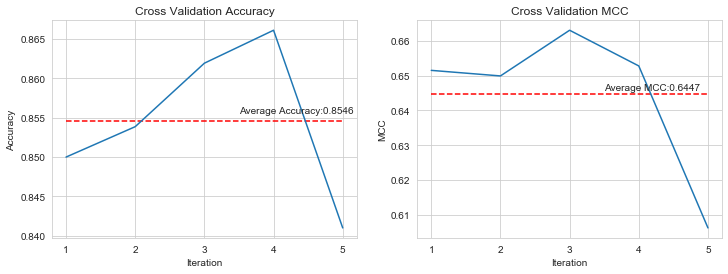

In [106]:
results = cross_validation_smote(5, X_train_scaled.values, y_train.values, lasso)


In [107]:
print("Cross Validation Results")

for key in results:
    print("{0}: {1}".format(key, np.mean(results[key])))


Cross Validation Results
accuracy: 0.8545799739694797
recall_score: 0.9710526315789474
precision: 0.5237561375984194
f1_score: 0.6802724789125699
roc_auc_score: 0.901782503831892
mcc: 0.6446864507148027


#### 5.2.2 Test Results

In [108]:
# Logistic regression model:
lasso = LogisticRegression(fit_intercept=True, penalty='l1', C=1/best_lambda, random_state=1234)

In [109]:
lasso_model = lasso.fit(sm_X_train, sm_y_train)

In [110]:
# Get predicted labels for validation data
y_pred_lasso = lasso_model.predict(X_test)

In [111]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_lasso)
TN, FP, FN, TP = cm.ravel()
print (cm)
print (TN, FP, FN, TP)

[[458  46]
 [ 35  60]]
458 46 35 60


In [112]:
# Performance of Logistic Regression with L1
print ("Accuracy: ", accuracy_score(y_test, y_pred_lasso))
print("Sensitivity: ", recall_score(y_test, y_pred_lasso))
print("Precision: ", precision_score(y_test, y_pred_lasso))
print ("f1 Score: ", f1_score(y_test, y_pred_lasso))
print("ROC_AUC_Score:", roc_auc_score(y_test, y_pred_lasso))
print("MCC: ", matthews_corrcoef(y_test, y_pred_lasso))


Accuracy:  0.8647746243739566
Sensitivity:  0.631578947368421
Precision:  0.5660377358490566
f1 Score:  0.5970149253731343
ROC_AUC_Score: 0.7701545530492899
MCC:  0.5171814811327795


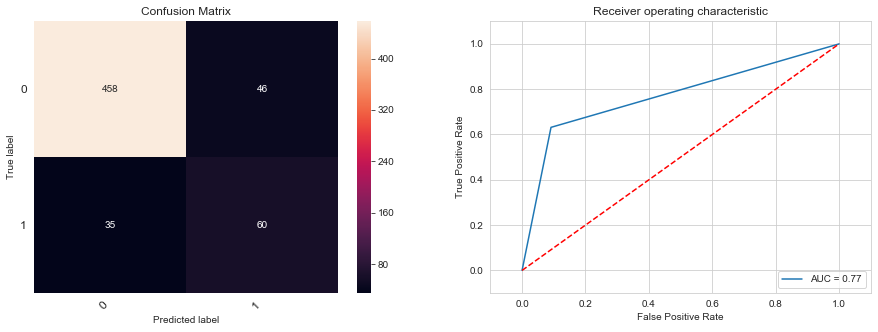

In [113]:
cm_and_roc(cm, [0, 1], y_test, y_pred_lasso, figsize = (15,5), fontsize=12)



### 5.3 Identify important features from lasso

In [114]:
lasso_coefficients = lasso_model.coef_[0]
lasso_coefficients

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -2.07746714e-02,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  2.79169109e-01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  4.15439414e-03,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  7.18386871e-04,  8.25847624e-01,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

In [115]:
index = [i for i in range(len(lasso_coefficients)) if lasso_coefficients[i]!=0]
index


[11, 15, 25, 46, 47, 55, 57, 63, 64, 65]

In [116]:
lasso_features = [features[j] for j in index]
lasso_features

['inq_fi',
 'int_rate',
 'mths_since_rcnt_il',
 'out_prncp',
 'out_prncp_inv',
 'tot_cur_bal',
 'total_acc',
 'total_pymnt',
 'total_pymnt_inv',
 'total_rec_int']

**Lasso Selected 10 Features**:
- inq_fi
- int_rate
- mths_since_rcnt_il
- out_prncp
- out_prncp_inv
- tot_cur_bal
- total_acc
- total_pymnt
- total_pymnt_inv
- total_rec_int

(b) (2 points) Did your intuition about the correct set of attributes in the REDUCED-MODEL match the results that you obtained from the LASSO-MODEL? Discuss.

Only 4 of our selected features (int_rate,total_pymnt,total_pymnt_inv,tot_cur_bal) in the REDUCED-MODEL match with the features in the LASSO-MODEL. The reason for the discrepancy can be attributed to the fact that the data does not exhibit the separation of customers (bad and normal loans) for each feature as described by our intuition, in particular for those wrongly identified features. 

For example, we expected a high dti to have more bad loans and a low dti to have less bad loans - but this is generally not reflected in the data. We can instead see that there is no distinction in the customers in the `dti` distribution. When we look at the 4 features that are included in the LASSO Model, we can see that `total_pymt` and `total_pymnt_inv` shows a very different distribution for both types of customers, while  `int_rate` and `tot_cur_bal` shows some differences especially at low values which could be used for identification. 
All in all, the lasso model could probably identify some form of correlation and distribution of the features to distinguish the type of loans which if based on just our observation and intuition, cannot be identified.

In [117]:
test = ['int_rate', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
'percent_bc_gt_75', 'dti', 'delinq_amnt'
]

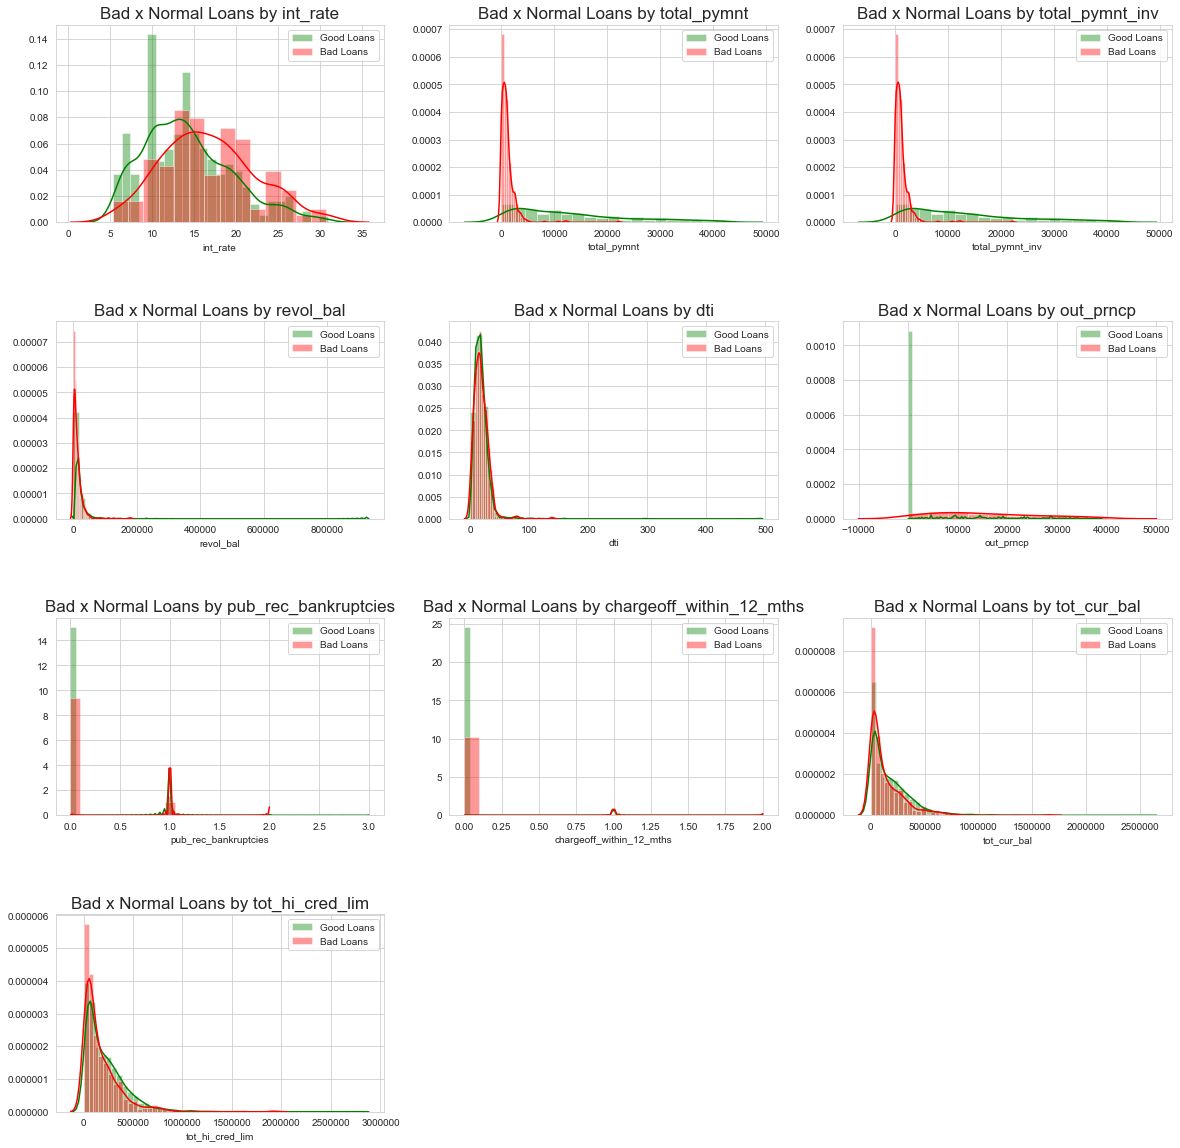

In [118]:
fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(hspace=0.5)

for i in range(1, len(selected_ten_features)+1):
    variable = selected_ten_features[i-1]
    plt.subplot(4, 3, i)
    sns.distplot(loans[loans['bad_loans'] == 0][variable], 
             color='g', label="Good Loans")
    sns.distplot(loans[loans['bad_loans'] == 1][variable], 
                 color='r', label="Bad Loans")
    plt.title('Bad x Normal Loans by {}'.format(variable), fontsize=17)
    plt.legend(prop={'size': 10})

## Question 6

6. (1 point) What other metric might you use to compare the performance of the different models? Explain what this metric means and how it might be computed. For this question, you will not have to compute the metric.

In this specific business context, we would use the F1 score. The F1 score is calculated as 2$*$((precision$*$recall)/(precision+recall)). It is a balance between precision and recall. Precision is calculated as TP/(TP+FP) and recall is calculated as TP/(TP+FN) also known as the true positive rate.

A good F1 score indicates that there are low false positives and false negatives. In this scenario, it is important to have low false positives because a high false positive rate means that we wrongly classified good customers as loan defaulters. Doing so would result in a loss of revenue from not issuing the loan to these customers. It is even more crucial to have low false negatives. This is because we do not want to wrongly classify potential loan defaulters as good customers. If the lending club were to issue loans to these customers, they would suffer a much heavier loss as these customers will have a higher risk of defaulting. 

Hence, when selecting the model, we would base it on the highest F1 score as another metric of evaluation. 


## Question 7

7. (2 points) How do the results using the full set of attributes FULL-MODEL and LASSO-model compare to those that you personally selected REDUCED-MODEL to predict if a loan will default? What do you think is more important in this particular example, the set of attributes, or the classification techniques? Discuss. 

**Comparison of Results:**

When comparing the models, we will be primarily using the Test Results as a basis of comparison because this allows us to see how the models perform on a truly unseen data. 

*(1) Full Model vs Reduced Model*

Observation:

The Full Model performed better on the test set both in Accuracy (86.48% against 84.64%) and MCC (63.20% against 62.99%) compared to our personally selected reduced model. 

Explanation:

This is because the Full Model considers all features and then uses `l2` regularization to penalise the weak features by means of statistical measures (e.g. does this one feature lead to a clear separation of class?). The different weights assigned to each feature helps to minimise overfitting of the Full Model and increases its predictive power. 

On the other hand, our hand-picked features were based off domain knowledge and not through a thorough understanding of the data. As such, we could have excluded the significant features from our reduced model. This reduces the predictive power of our reduced model. 


*(2) Lasso Model vs Reduced Model*

Observation:

- Looking at the Test results, the Lasso Model performed slightly better than the Reduced Model in Accuracy (86.48% against 84.64%) but worse than the Reduced Model in MCC (51.72% against 62.99%). 

- Looking at the CV results, the Lasso Model performed fairly similar both in Accuracy (85.46% against 85.83%) and MCC (64.47% against 65.06%) compared to the Reduced Model. 

Explanation:

For the first observation, we do not have a conclusive explanation. 

However, for the second observation, we believe the similar CV performance could be because we managed to identify strong features such as ‘total_pymnt’ and ‘out_prncp’ that are able to separate the classes well. In addition, we are using `l2` regularization for our Reduced Model, which will lower the weight of the coefficient of those poor features we have chosen. 

*(3) Full Model and Lasso Model vs Reduced Model*

Observation:

When comparing the Test Accuracy, the Lasso Model and the Full Model perform equally well, while our Reduced Model has the lowest accuracy. 

Explanation:

Both the Full Model and Lasso Model have similar performance results because they both consider the full feature set and then apply a penalty to the weak features - (reduce the coefficient of weak features close to 0 for `l2` in Full Model; penalise the coefficient of weak features to equal to 0 for `l1` in Lasso Model. This minimises overfitting and allow them to have a much better predictive performance. 

As mentioned above, we could have accidentally excluded some significant features in our reduced model, which explains the relatively poor performance in test accuracy. 

**Set of Attributes or Classification Techniques:**

In our opinion, we feel the classification technique is more important. While the set of attributes used contributes largely to the performance of the classifier, the classifier has its own inbuilt parameters to select the best set of attributes eg `l1` and `l2` regularization/ Max Features. If we understand the parameters of a model well, we could utilise it to select the best set of attributes for us. In addition, it is evident from the results of the Full Models and Reduced Models, that classification methods are more important, as given the same set of attributes, the XGBoost always outperforms the other 2 classifiers. 

### Note: Question 8 is done in a seperate notebook.